# 1. Background:

Convolutional Neural Networks (CNNs) are fundamental to brain imaging. They function by applying a series of convolutional operations to an image.

CNNs apply this filtering operation repeatedly in varying sizes and formats, allowing the model to gain an *understanding* of the image. However, the complexity of the model increases substantially with the addition of more filters, leading to intensive memory and computational demands due to the vast complexity and numerous parameters [1].

A layer known as Max Pooling is incorporated into these networks. This layer maintains the same depth of the model while reducing its spatial size, thereby enhancing computational efficiency. It also preserves the key features of an image [2]. Several other layers are similarly employed to manage computation by adjusting either the depth or spatial size of the model.

It was however observed that some uncertainty propagates through the network using these techniques. For instance, assume the following 4x4 matrix:

$$
\begin{bmatrix}
7 & 7 \\
4 & 5
\end{bmatrix}
$$

A max pooling layer needs to choose which of the 7s to keep, and later, during upsampling, remember the index where the 7 was found. Different implementations or software stacks can cause different issues and contribute to numerical unstability.

# 2. Introduction

Observations from Dr. Glatard's lab suggest that replacing such occurrences with NaN values could potentially improve computational speed during both training and inference, while preserving the accuracy of the model. The logic is that parts of images with redundant information (e.g., the background) could be disregarded during the convolutional operation, as image patches containing a high count of NaN values might be ignored. Likewise, this will solve the problem mentioned above. This is hypothesized to accelerate the calculations in convolutional operations.

A Python implementation of this NaN pooling has already been developed with success in the lab, which showed promising results. However, to fully harness the potential of this approach, it must be adapted to PyTorch's C/C++ framework.

Hence, the following project is proposed: Can a C/C++ PyTorch implementation of this solution improve the speed of inference and training of CNN models and prevent uncertainty propagation while conserving current accuracy benchmarks?


# 3 Approach 1: Re-writing the current NaN python implementation using Torch's C++ extension framework

Torch offers an elegant [solution](https://pytorch.org/tutorials/advanced/cpp_extension.html) to writing your own custom C++ extensions. In essence, including the following header ```#include <torch/extension.h>``` in your C++ code, and creating a python setup.py file allows you to use Torch's existing C++ frontend, as well as extending it. 

To do so, we first created the following build files:

---
Dockerfile:
```Dockerfile
Use the latest PyTorch base image with CUDA 12.1 and cuDNN 8
FROM pytorch/pytorch:2.2.1-cuda12.1-cudnn8-devel

# Install necessary dependencies
RUN apt-get update && apt-get install -y \
    build-essential \
    cmake \
    git \
    python3-dev \
    python3-pip \
    libpython3-dev \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*

# Copy requirements.txt and install Python dependencies
COPY requirements.txt /workspace/requirements.txt
WORKDIR /workspace

# Install Python dependencies
RUN pip install --upgrade pip && \
    pip install -r requirements.txt --no-cache-dir

# Copy files into workspace
COPY . /workspace

# Set the working directory
WORKDIR /workspace
```

---
docker-compose.yml
```yaml
services:
  pytorch_cpp_extension:
    image: pytorch_cpp_extension
    build:
      context: .
    volumes:
      - .:/workspace
    working_dir: /workspace
    entrypoint: /bin/bash -c "python setup.py build_ext --inplace && python setup.py install && /bin/bash"
```

--- 
setup.py 
```python
from setuptools import setup, Extension
from torch.utils import cpp_extension

setup(
    name='nan_cpp',
    ext_modules=[cpp_extension.CppExtension('nan_cpp', ['nan.cpp'], extra_compile_args=["-g"])],
    cmdclass={'build_ext': cpp_extension.BuildExtension}
)
```

---
Combined together, these three files allow the user to create the necessary environment to build their own extensions. Furthermore, the .yml file allows for automatic mounting. By calling 

```docker-compose run --rm pytorch_cpp_extension```

A docker image will be built and and the user will be automatically attached. This will also call the necessary commands to build, compile and link the C++ and python files.




Let's take a first stab at implementing python NaN Pooling based on the following code (code can be found in the file nan_ops.py): 

```python
class NaNPool2d:

    def __init__(self, max_threshold: float = 1):
        """
        Initializes the NaNPool2d object.

        Args:
            max_threshold (float, optional): Max threshold value for determining multiple max value occurrence ratio. Defaults to 0.5.
        """
        self.max_threshold = max_threshold


    def check_for_nans(self, c, i, j, window, maxval, max_index):

        # Converting 1d indices from pool window to 2d indices
        max_index = torch.stack((max_index // self.pool_height, max_index % self.pool_width), dim=1)

        if torch.isnan(maxval).any():
            window = window.masked_fill(torch.isnan(window), float("-inf"))
            maxval = torch.max(window.reshape(self.batch_size, -1), dim=1)[0] 

        # Strict approach to identifying multiple max values
        # check_multi_max = torch.sum(window == maxval[:, None, None], axis=(1, 2))
        # Less restrictive more theoretically stable approach
        check_multi_max = torch.sum(
            torch.isclose(window, maxval[:, None, None], rtol=1e-7, equal_nan=True), axis=(1, 2)
        )
       
        # Reduce multiple max value counts to ratios in order to use passed max threshold value
        # check_multi_max = check_multi_max / (window.shape[-1] * window.shape[-2])

        if (check_multi_max > self.max_threshold).any():
            maxval = torch.where(check_multi_max > self.max_threshold, np.nan, maxval)

        # Find new index of max value if it has changed and is not NaN
        if torch.where(window == maxval)[0].numel() != 0: 
            max_index = torch.max(window.masked_fill(torch.isnan(window), float('-inf')).reshape(self.batch_size, -1), dim=1)[1]
            max_index = torch.stack((max_index // self.pool_height, max_index % self.pool_width), dim=1)

        # Calculate the indices for 1D representation
        max_index_1d = (i * self.stride_height + (max_index[:, 0])) * self.input_width + (
            j * self.stride_width + (max_index[:, 1])
        )


        self.output_array[:, c, i, j] = maxval
        self.index_array[:, c, i, j] = max_index_1d


    def __call__(self, input_array: torch.Tensor, pool_size: Tuple, strides: Tuple = None) -> Tuple:
        """
        Perform NaN-aware max pooling on the input array.

        Args:
            input_array (torch.Tensor): Input tensor of shape (batch_size, channels, input_height, input_width).
            pool_size (tuple): Size of the pooling window (pool_height, pool_width).
            strides (tuple, optional): Strides for pooling (stride_height, stride_width). Defaults to None.

        Returns:
            tuple: A tuple containing output array and index array after pooling.
        """

        batch_size, channels, input_height, input_width = input_array.shape
        # Force values to int
        self.batch_size = int(batch_size)
        channels = int(channels)
        self.input_height = int(input_height)
        self.input_width = int(input_width)

        pool_height, pool_width = pool_size
        # Force values to int
        self.pool_height = int(pool_height)
        self.pool_width = int(pool_width)

        if strides:
            stride_height, stride_width = strides

        else:
            stride_height, stride_width = pool_size

        # Force values to int
        self.stride_height = int(stride_height)
        self.stride_width = int(stride_width)

        # Calculate simplified intensity distribution of the layer
        self.min_intensity = torch.min(input_array)
        self.max_intensity = torch.max(input_array)

        # Calculate the output dimensions
        output_height = int((input_height - pool_height) // stride_height + 1)
        output_width = int((input_width - pool_width) // stride_width + 1)

        # Initialize output arrays for pooled values and indices
        self.output_array = torch.zeros((self.batch_size, channels, output_height, output_width))
        self.index_array = torch.zeros((self.batch_size, channels, output_height, output_width), dtype=torch.int64)


        # Perform max pooling with list comprehensions
        for c in range(channels):

            # Create a list of tuples with pooled values and indices
            values_and_indices = [
                self.check_for_nans(c, i, j, window, torch.max(window.reshape(self.batch_size, -1), dim=1)[0], torch.max(window.reshape(self.batch_size, -1), dim=1)[1])
                for i in range(output_height)
                for j in range(output_width)
                for window in [
                    input_array[
                        :,
                        c,
                        i * stride_height : i * stride_height + pool_height,
                        j * stride_width : j * stride_width + pool_width,
                    ]
                ]
            ]

        return torch.Tensor(self.output_array), torch.Tensor(self.index_array).type(torch.int64)
``` 
---

**It's corresponding C++ torch extension is defined as follows:**

```cpp
#include <torch/extension.h>
#include <optional>
#include <iostream>
#include <tuple>

// Struct to hold pooling attributes
struct PoolingAttributes {
    int batch_size;          // Number of samples in a batch
    int channels;            // Number of channels in the input tensor
    int input_height;        // Height of the input tensor
    int input_width;         // Width of the input tensor
    int pool_height;         // Height of the pooling window
    int pool_width;          // Width of the pooling window
    int stride_height;       // Height of the stride
    int stride_width;        // Width of the stride
    float threshold;         // Threshold to determine if a max value is ambiguous
    torch::Tensor input_tensor;  // The input tensor
    torch::Tensor output_tensor; // The output tensor for pooled values
    torch::Tensor index_tensor;  // The output tensor for pooled indices
};

// Function to check for NaNs in the pooling window and update the output tensors
std::tuple<torch::Tensor, torch::Tensor> check_for_nans(
    PoolingAttributes& attrs,
    torch::Tensor window, 
    torch::Tensor maxval, 
    torch::Tensor max_index,
    int c, 
    int i, 
    int j
) {
    // Convert 1D indices from the pooling window to 2D indices
    max_index = torch::stack({max_index / attrs.pool_height, max_index % attrs.pool_width}, 1);
    // If any of the max values are NaN, replace NaNs in the window with -infinity and recompute max values
    if (torch::isnan(maxval).any().item<bool>()) {
        window.masked_fill_(torch::isnan(window), -std::numeric_limits<float>::infinity());
        maxval = std::get<0>(torch::max(window.reshape({attrs.batch_size, -1}), 1));
    }
    
    
    // Check if multiple values are close to the max value
    auto reshaped_maxval = maxval.unsqueeze(1).unsqueeze(2);

    // Perform the isclose comparison with the specified rtol and equal_nan=True
    auto close_to_max = torch::isclose(window, reshaped_maxval, 1e-7, 1e-7, true);
    auto check_multi_max = torch::sum(close_to_max, {1, 2});
    

    // If the proportion of close values exceeds the threshold, set the max value to NaN
    if ((check_multi_max > attrs.threshold).any().item<bool>()) {
        auto nan_tensor = torch::full_like(maxval, std::numeric_limits<float>::quiet_NaN());
        maxval = torch::where(check_multi_max > attrs.threshold, nan_tensor, maxval);
    }

    // Type-casting to int
    max_index = max_index.toType(torch::kInt64);

    // Find new index of max value if it has changed and is not NaN
    // std::cout << "max_index: " << max_index << std::endl;
    auto non_zero_elems = torch::where(window == maxval)[0].numel();
    if (non_zero_elems != 0) {
        auto max_vals = torch::max(
            window.masked_fill(torch::isnan(window), -std::numeric_limits<float>::infinity()).view({attrs.batch_size, -1}), 1
        );
        max_index = std::get<1>(max_vals).toType(torch::kInt64);
        // std::cout << "max_index during: " << max_index << std::endl;
        max_index = torch::stack({max_index / attrs.pool_width, max_index % attrs.pool_width}, 1);
    }
    max_index = max_index.toType(torch::kInt64);
    // Convert the 2D indices back to 1D
    auto max_index_1d = 
        (i * attrs.stride_height + max_index.index({torch::indexing::Slice(), 0})) * attrs.input_width + 
        (j * attrs.stride_width + max_index.index({torch::indexing::Slice(), 1}));

    

    // Update the output tensors with the computed max values and indices
    attrs.output_tensor.index_put_({
        torch::indexing::Slice(), 
        c, 
        i, 
        j
        }, maxval.view({attrs.batch_size}));
    attrs.index_tensor.index_put_({
        torch::indexing::Slice(), 
        c, 
        i, 
        j}, max_index_1d.view({attrs.batch_size}));

    return std::make_tuple(attrs.output_tensor, attrs.index_tensor);
}

// Main function to perform NaN-aware max pooling
std::tuple<torch::Tensor, torch::Tensor> NaNPool2d(
    torch::Tensor input_tensor, 
    std::tuple<int, int> pool_size, 
    float threshold = 0.5, 
    std::optional<std::tuple<int, int>> strides = std::nullopt
) {
    // Extract the size of the input tensor
    auto size = input_tensor.sizes();
    PoolingAttributes attrs;
    attrs.batch_size = size[0];
    attrs.channels = size[1];
    attrs.input_height = size[2];
    attrs.input_width = size[3];

    // Unpack the pool size
    std::tie(attrs.pool_height, attrs.pool_width) = pool_size;

    // Unpack or set default strides
    if (strides) {
        std::tie(attrs.stride_height, attrs.stride_width) = strides.value();
    } else {
        std::tie(attrs.stride_height, attrs.stride_width) = pool_size;
    }

    // Set the threshold and input tensor
    attrs.threshold = threshold;
    attrs.input_tensor = input_tensor;

    // Calculate the output dimensions
    int output_height = (attrs.input_height - attrs.pool_height) / attrs.stride_height + 1;
    int output_width = (attrs.input_width - attrs.pool_width) / attrs.stride_width + 1;

    // Initialize the output tensors for pooled values and indices
    attrs.output_tensor = torch::zeros({attrs.batch_size, attrs.channels, output_height, output_width});
    attrs.index_tensor = torch::zeros({attrs.batch_size, attrs.channels, output_height, output_width}, torch::kInt64);

    // Perform max pooling with NaN handling
    for (int c = 0; c < attrs.channels; c++) {
        for (int i = 0; i < output_height; i++) {
            for (int j = 0; j < output_width; j++) {
                // Extract the current pooling window
                torch::Tensor window = attrs.input_tensor.index({
                    torch::indexing::Slice(),
                    c,
                    torch::indexing::Slice(i * attrs.stride_height, i * attrs.stride_height + attrs.pool_height),
                    torch::indexing::Slice(j * attrs.stride_width, j * attrs.stride_width + attrs.pool_width)
                });

                // Reshape the window for max pooling
                torch::Tensor reshaped_window = window.reshape({attrs.batch_size, -1});

                // Compute the max values and their indices in the window
                auto max_result = torch::max(reshaped_window, 1);
                auto max_values = std::get<0>(max_result);
                auto max_indices = std::get<1>(max_result);

                // Check for NaNs and update the output tensors
                std::tie(attrs.output_tensor, attrs.index_tensor) = check_for_nans(
                    attrs,
                    window, 
                    max_values, 
                    max_indices,
                    c, 
                    i, 
                    j
                );
            }
        }
    }

    return std::make_tuple(attrs.output_tensor, attrs.index_tensor);
}

// Bind the function to Python
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("NaNPool2d", &NaNPool2d, "Create a NaN pooling layer. Returns a tuple of tensors.");
}
```
---


The implementation tries to follow the given Python logic 1:1.

Example sliding window example:
$
\begin{bmatrix}
7 & 7 \\
4 & NaN
\end{bmatrix}
$ &rarr;
$
\begin{bmatrix}
7 & 7 \\
4 & -inf
\end{bmatrix}
$ &rarr;
$
\begin{bmatrix}
NaN & NaN \\
4 & -inf
\end{bmatrix}
$


*Max Value*: NaN, *Returned Index*: 0

The algorithm works as follows:

---

*It follows the same mechanics as a regular pooling (i.e., a sliding window going over the input tensor. Pool size, stride, and other parameters have their regular definition).*

1. **Initialization**:
   - The class is initialized with an optional threshold value (`max_threshold`) that determines how to handle cases where multiple maximum values are found in the pooling window.

2. **Max Pooling with NaN Handling**:
   - The algorithm iterates over each channel of the input tensor and performs max pooling in a sliding window fashion.
   - For each window, it checks for NaN values and replaces them with negative infinity to ensure they are not considered in the max value computation.
   - It calculates the maximum value in the window.
   - If multiple maximum values are found that exceed the threshold, these max values are replaced with NaN.

3. **Index Conversion**:
   - Converts the max indices from 1D to 2D format for proper placement in the pooled output.

4. **Output and Index Arrays**:
   - Maintains arrays for storing the pooled values and their corresponding indices.
   - Updates these arrays with the computed max values and their indices for each window.


# 4. Comparison of results of NaNpool in python, NaNPool in Torch C++, PythonPool implementation and Torch Max Pool

In the following cells, we will be running and evaluating different forms of max pooling and comparing their results, both in terms of execution speed and viusal results. 

There are four implementations: 
1. NaNPool Python: The class defined above that handles NaNs\DuplicateMax according to custom written rules.
2. NaNPool C++: The same class but written in C++ using torch extensions
3. Normal Pool: Python implementation of Max Pooling that doesn't handle NaNs\DuplicateMax in any special ways.
4. TorchPool: Torch implementation of MaxPool

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import nan_cpp as nanCPP
import time
from nan_ops import NaNPool2d, NormalPool2d, NaNConv2d, NormalConv2d
FILENAME = "mri_data//sample_data//outp_bn3_1.pkl"
# Load the data from the pickle file
data = pickle.load(open(FILENAME, 'rb'))

if isinstance(data, tuple):
    a = data[0]
else:
    a = data

# Comparison of different pooling operations

First, we begin with a C++ implementation which can be found under nan.cpp. It converts the custom NaN pooling classes into C++, to hopefully improve the speed of execution of these files (or, in the very least, improve the speed of further convolutional layers). This was built following C++ frontent Torch libraries that are found [here](https://pytorch.org/cppdocs/frontend.html).

C++ Pooling

In [2]:
%%timeit -o -n 1 -r 10
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 1, None)


1min 37s ± 26.2 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 1min 37s ± 26.2 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [3]:
cppTime = _

In [4]:
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 1, (2,2))

Let's run the NaNPooling, python pooling, and torch pooling to compare speeds.

NaNPooling Pooling

In [5]:
%%timeit -o -n 1 -r 10
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


2min 23s ± 16.9 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 2min 23s ± 16.9 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [6]:
pyTime = _

In [18]:
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Normal Pool

In [8]:
%%timeit -o -n 1 -r 10
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


44 s ± 2.48 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 44 s ± 2.48 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [9]:
normalTime = _

In [10]:
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Torch Pool

In [11]:
%%timeit -o -n 1 -r 10
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)

The slowest run took 6.90 times longer than the fastest. This could mean that an intermediate result is being cached.
4.45 ms ± 4.53 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 4.45 ms ± 4.53 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [12]:
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)

In [13]:
torchTime = _

Visualizing the pooling

It's time to visualize the pooling. For reference here is the mapping between the different layers and their implementation.
- nanCPP.NaNPool2d -> NaN aware pooling built in *C++*
- NaNPool2d -> NaN aware pooling built in *Python*
- NormalPool2d -> NaN **un**aware pooling built in *Python*
- torch.nn.MaxPool2d -> NaN **un**aware pooling built in *PyTorch*

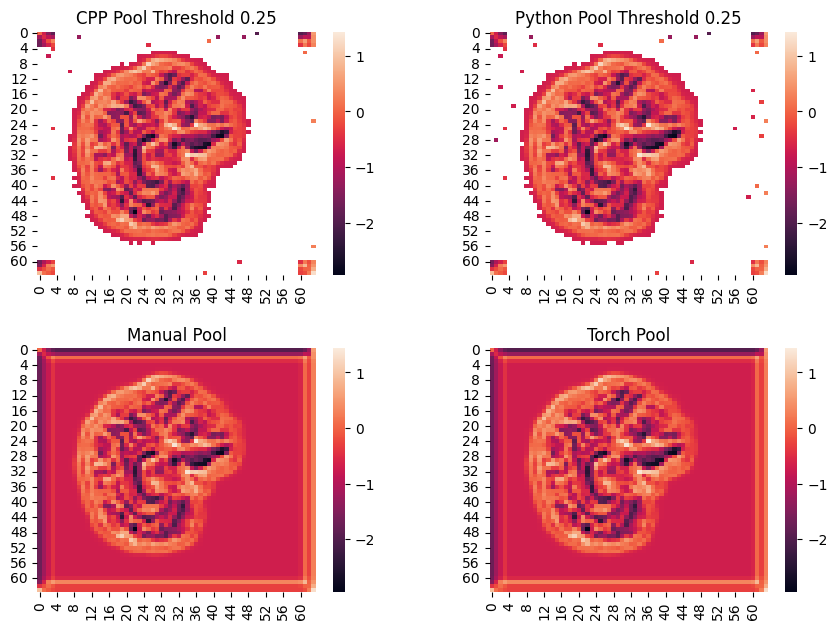

In [20]:
# Visualize output
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

sns.heatmap(np.mean(nanoutput.detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')
sns.heatmap(np.mean(nanoutputPy.detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')
sns.heatmap(np.mean(normaloutput.detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')
sns.heatmap(np.mean(torchoutput.detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

Visualizing the difference between both

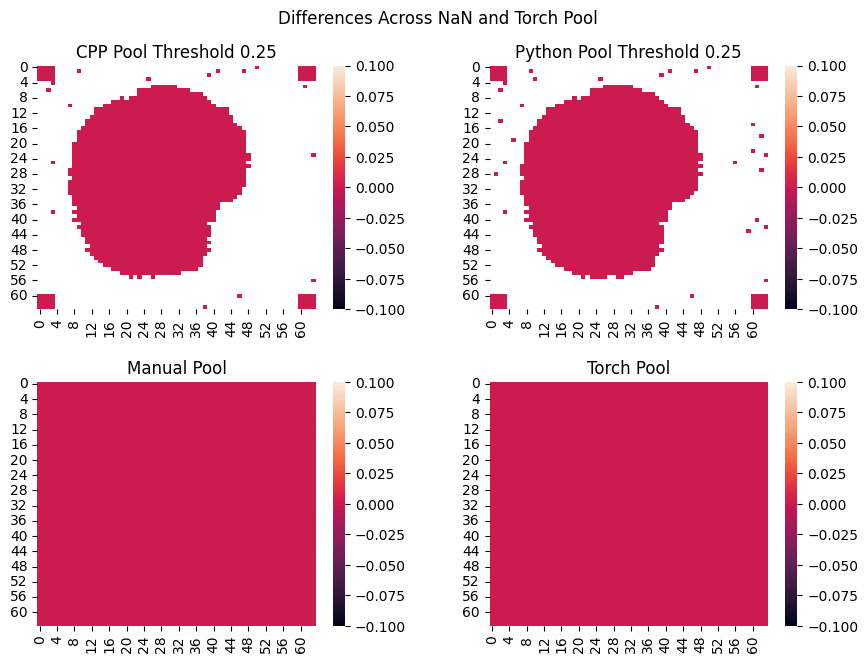

In [19]:
# %%timeit
# Visualize output differences -- should be 0
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Adjusted figure size for better layout

sns.heatmap(np.mean((nanoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')

sns.heatmap(np.mean((nanoutputPy - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')

sns.heatmap(np.mean((normaloutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')

sns.heatmap(np.mean((torchoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')

plt.suptitle('Differences Across NaN and Torch Pool')
# plt.savefig('/workspace/differences_comparison.png')  # Save the second plot
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

It can observed that the differences between both implementations (c++ and python) are very minimal. There are some small differences, mainly on the RHS of the image. However, C++ seems to ignore the background image a little better.



Exploring the time taken for each method

In [16]:
cpp_time = cppTime.average
py_time = pyTime.all_runs
normal_time = normalTime.all_runs
torch_time = torchTime.all_runs

cpp_time

97.62031910540027

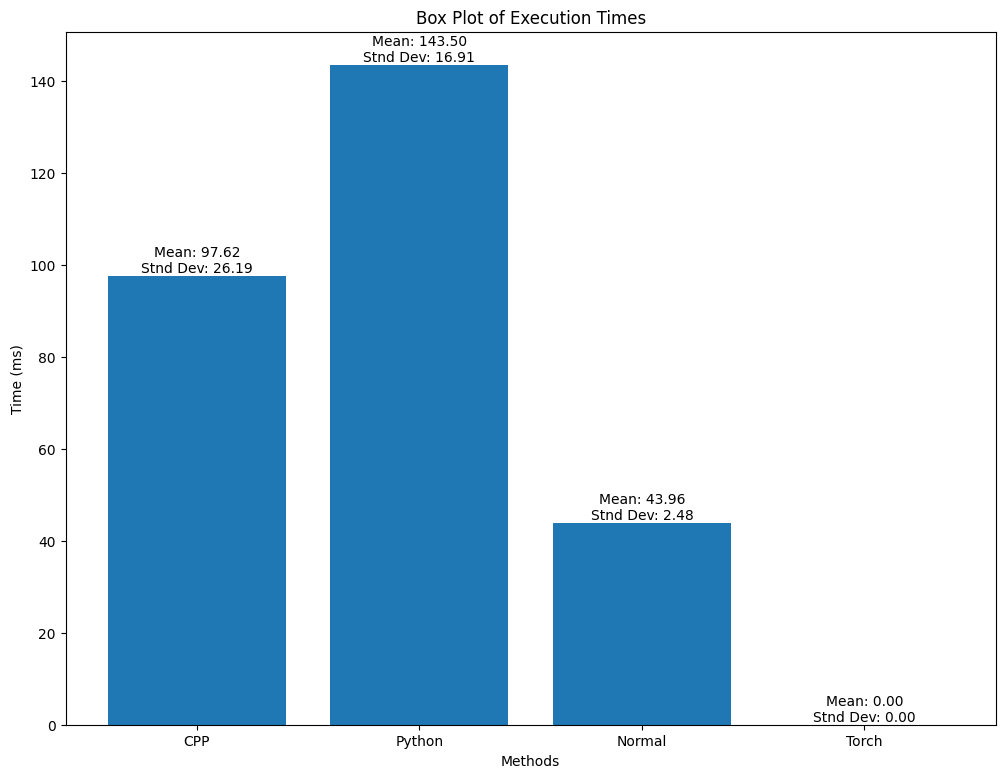

In [17]:
methods = ['CPP', 'Python', 'Normal', 'Torch']
times_objects = [cppTime, pyTime, normalTime, torchTime]

# Extracting the vectors from the time objects
cpp_time = cppTime.average
py_time = pyTime.average
normal_time = normalTime.average
torch_time = torchTime.average

# Extracting the standard deviations
cpp_std = cppTime.stdev
py_std = pyTime.stdev
normal_std = normalTime.stdev
torch_std = torchTime.stdev

times = [cpp_time, py_time, normal_time, torch_time]
times_stnd_dev = [cpp_std, py_std, normal_std, torch_std]

fig, ax = plt.subplots(figsize=(12, 9))  # Create a new figure with a single subplot
bars = ax.bar(methods, times, capsize=25)  # Create a bar chart
ax.set_title('Box Plot of Execution Times')
ax.set_xlabel('Methods')
ax.set_ylabel('Time (ms)')

# Adding the mean and stnd dev to make more readable
for bar, mean, std_dev in zip(bars, times, times_stnd_dev):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'Mean: {mean:.2f}\nStnd Dev: {std_dev:.2f}',
            ha='center', va='bottom')
plt.show()  # Display the figure

By observing the box plot, we notice a slight decrease in execution time between the Python and C++ implementations, as expected. Interestingly, the custom-written normal pooling method is faster than the NaN pooling method. This is expected because the computational speedup for NaN layers should be realized during the custom NaN convolution operation at the cost of a slower max pooling layer. NaNPooling involves additional comparisons to check for NaNs and duplicates, and to replace these values as necessary, which is not required in normal max pooling. However, during NaNConv, some convolutions should be skipped which should mean that we will see a faster execution time.

Given Torch's highly optimized code, matching its speed with our custom layers will be challenging. Notably, they can have different mathematical implementations (i.e., seperable filter, recursive convolution, using FFT [3]) or simply parallelizing the convolution operation [**source**]. However, if we can demonstrate that NaNPooling and NaNConv are faster than normal pooling and convolution, we can argue that NaN layers could outperform Torch's layers if subjected to the same level of optimization.

It can be observed that the improvement seen in our case reflect those found in pytorch's documentation found [here](https://pytorch.org/tutorials/advanced/cpp_extension.html). Their improvement takes about ~67% of the initial time whereas our takes about ~68% of our initial time. 

Documentation Example:
- Python custom implementation `Forward: 506.480 us | Backward 444.694 us`
- C++ custom implementation `Forward: 349.335 us | Backward 443.523 us`

NaN Pooling
- NaNPython custom implementation `NaNPooling: 143.50 sec`
- C++ custom implementation `NaNPooling: 97.62 sec`

# 5.0 Re-implementing in Torch Source

The observed disparity between the Torch source code and our custom implementation is too significant to overlook. Torch is exceptionally optimized, featuring custom MaxPooling functions tailored to the specific hardware executing the function, and is fine-tuned on a case-by-case basis. Consequently, recreating the custom implementations would be a monumental task. Instead of attempting to surpass its speed on our own, we will modify the specific function (e.g., by adding NaN checks, etc.), leveraging the existing work. This approach enables us to enhance and optimize our code without the need to start from scratch.

## 5.1 Source code installation
Similar to the Torch extension, a dockerfile and a .yml were used to ensure compatibility across OS's, reusability and to create contained envrionments. 

conda_env.yml file
```yaml
name: torch_source
channels:
  - pytorch
  - defaults
dependencies:
  - python=3.10
  - cmake
  - clang
  - git
```
---
Note, the current dockerfile builds a container which is useful if you only want to run the files loaded. For example, if you only want to run a file that is built and ready to be deployed. If you want to develop your own stuff using torch source, I recommend the follwing:
1. Commenting out the ```git``` commands and the last ```run``` command. 
2. forking the repo of your choice on your local computer
3. Mounting that directory to the container
4. Run the last ```run``` commmand manually once in the container.

Dockerfile 
```Dockerfile
FROM ubuntu:20.04

# Set environment variables
ENV DEBIAN_FRONTEND=noninteractive
ENV LANG=C.UTF-8
ENV LC_ALL=C.UTF-8
ENV PATH /opt/conda/bin:$PATH

# Install required dependencies
RUN apt-get update && apt-get install -y --no-install-recommends \
    wget \
    build-essential \
    ca-certificates \
    libjpeg-dev \
    libpng-dev \
    git \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*


RUN git clone --recursive https://github.com/pytorch/pytorch.git \
&& cd pytorch \
&& git checkout viable/strict \
&& git submodule sync \
&& git submodule update --init --recursive

# Install Anaconda
RUN wget --quiet https://repo.anaconda.com/archive/Anaconda3-2022.05-Linux-x86_64.sh -O /tmp/anaconda.sh && \
    /bin/bash /tmp/anaconda.sh -b -p /opt/conda && \
    rm /tmp/anaconda.sh
    
# Initialize Conda
COPY conda_env.yml conda_env.yml
RUN /opt/conda/bin/conda env create -f conda_env.yml
# Ensure the conda environment is activated for subsequent RUN commands
SHELL ["conda", "run", "-n", "torch_source", "/bin/bash", "-c"]

# Copy PyTorch requirements.txt and install PyTorch dependencies
RUN conda run -n torch_source pip install -r /pytorch/requirements.txt

RUN conda run -n torch_source conda install -y \
    intel::mkl-static \
    intel::mkl-include \
    && conda run -n torch_source conda clean -ya

# Fix ownership for git safety
RUN git config --global --add safe.directory '*'


ARG MAX_JOBS=$(nproc)
ARG USE_CUDA=0

# Additional instructions
RUN /bin/bash -c "source activate torch_source && \
                  cd /pytorch && \
                  export CMAKE_PREFIX_PATH=${CONDA_PREFIX:-"$(dirname $(which conda))/../"} && \
                  DEBUG=1 MAX_JOBS=${MAX_JOBS} USE_CUDA=${USE_CUDA} python setup.py develop --verbose"
```
---

This Dockerfile can be built and activated as follows:
1. Ensure you're in the folder containing Dockerfile and conda-env.yml 
2. ```docker build --no-cache --build-arg MAX_JOBS=16 -t <image-name> . ```
3. ```docker run --rm -it -v "$PWD:/workspace" <image_name>```

*** Note: this mounts your computer to /workspace in the docker container. In this case, it will create a new /workspace folder in the container. I recommend using ```mv``` to move the pytorch files into that workspace, so any changes made are saved after closing the environment. 

Once in the environment: 
1. Activate conda environment &rarr; ```source activate torch_source```
2. ```cd pytorch```

To test if everything is working, one can run any torch command in a python shell (launched from the /pytorch directory)

After any changes to C++ files, make sure to run python ```setup.py develop``` to recompile the C++ files.

The build can be customized for difference scenarions (in the dockerfile + build commands, it was specified that cuda wasn't used and to use 16 cpus.). More settings exist on Torch documentation that can be inserted\modified into this build file. 

Some common mistakes that can happen: 
1. Process killed &rarr; ussually means running out of memory. Running *dmesg* can confirm this. &rarr; Can decrease MAX_JOBS
2. Might have a unstable version of github (make sure you're pulling from viable/strict if you're cloning yourself and not using the provided Dockerfile)
3. Other build flags that can be used (examples): DEBUG=1 USE_DISTRIBUTED=0 USE_MKLDNN=0 USE_CUDA=0 BUILD_TEST=0 USE_FBGEMM=0 USE_NNPACK=0 USE_QNNPACK=0 USE_XNNPACK=0




# 6.0 Understanding Torch Architecture

## 6.1 Understanding the code, structured vs unstructured kernels

Structured kernels are the newer approach to writing operations in PyTorch. They simplify the process by generating much of the associated boilerplate code through code generation.

While structured kernels provide a clean and consistent way to handle many operations in PyTorch, some operations, like convolutions, remain as direct implementations due to historical reasons and the need for highly optimized and flexible code. For instance, convolutions often directly utilize platform-specific libraries like MKL-DNN (oneDNN) for CPU or cuDNN for CUDA. These libraries have their own optimized routines that might not fit neatly into the structured kernel framework involving separate *meta* and *impl* functions.

Finally, as mentioned, some operations in PyTorch are implemented directly within the framework, while others leverage specialized libraries. For example, standard convolutions often utilize BLAS libraries for their implementation, whereas depthwise convolutions have custom implementations in PyTorch.

A general guideline to determine the implementation location is as follows:

- Generic Math Operations (e.g., convolution as matrix multiplication):
  - You'll likely eventually be shipped to a math/specific library or backend such as BLAS.
- Specific, Custom Implementations:
  - Likely found within PyTorch's native codebase, often in the `/native` directory.
  - However, some implementations are proprietary so you won't find the specific implementations, only data preparation to call these functions.

For functions defined inside pytorch, what generally happens is that the code trace will eventually land inside ```/native```, and this will be re-routed to one of backend folders, and you can find specific implementations in one of those folders (eg., *DepthwiseConvKernel*.cpp's cpu implementation is found in ```/pytorch/aten/src/Aten/native/cpu```)

Hence, a good starting point is `pytorch/aten/src/ATen/native/`, which contains all the native C++ implementations relating to tensors [2]. Appendix has a slightly more descriptive defintions of the folders in Torch.

Let's begin by tracing the convolution in torch. 

*Special Note: 
PyTorch dynamically selects the backend for convolution operations based on input tensor size to optimize performance, as mentioned above. For larger batch sizes, such as 2, it uses the efficient MKL-DNN backend (for intel CPUs), while for smaller batch sizes, like 1, it switches to a more general but slower backend to reduce overhead.*

## 6.2 Unstructured Kernels Example - Convolution

Let's look at the most basic implementation of convolution, no special hardware and running on CPU.

In the case of convolution, here is the trace stack. Note: there are many function calls before this, but they're mainly bindings from Python to C++, and do some type converting etc.

1. Entry point: ```Convolution.cpp```

The first entry into the C++ world is found in the native folder inside `convolution.cpp`. This file can be seen as a very coarse filter, and the first C++ API. It performs some checks on the input and kernel, and dispatches to other files based mostly on the type of backend (e.g., GPU vs. CPU) (# threads being used etc.). This dispatching is mostly done in the function `_convolution`. Looking at a small sample of the code, we can see this dispatch mechanism:

```c++
switch (backend) {
    case ConvBackend::CudaDepthwise2d:
      output = at::_conv_depthwise2d(input.contiguous(), weight, kernel_size, bias,
          params.stride, params.padding, params.dilation);
      break;
    case ConvBackend::CudaDepthwise3d:
      output = at::conv_depthwise3d(input.contiguous(), weight, kernel_size, bias,
          params.stride, params.padding, params.dilation);
      break;
    case ConvBackend::Cudnn:
      check_input_same_type_as_parameters(input, weight, bias);
      output = at::cudnn_convolution(
          input.contiguous(backend_memory_format), weight, params.padding, params.stride,
          params.dilation, params.groups, params.benchmark, params.deterministic, params.allow_tf32);
      if (bias.defined()) {
        output.add_(reshape_bias(input.dim(), bias));
      }
      break;
    case ConvBackend::CudnnTranspose:
      check_input_same_type_as_parameters(input, weight, bias);
      output = at::cudnn_convolution_transpose(
          input.contiguous(backend_memory_format), weight, params.padding, params.output_padding,
          params.stride, params.dilation, params.groups, params.benchmark, params.deterministic, params.allow_tf32);
      if (bias.defined()) {
        output.add_(reshape_bias(input.dim(), bias));
      }
      break;
    case ConvBackend::Empty:
       // Other cases...
```

2. Fine-grained implementation: ```convolutionMM2d.cpp```

Eventually we hit this code:

```c++
case ConvBackend::Slow2d:
      return at::thnn_conv2d(input, weight, kernel_size, bias, params.stride, params.padding);
```

Which will eventually bring us to the implementations of convolutions optimized for CPU, which are found in ```convolutionMM2d.cpp```.

This new file includes helper functions for shape checking and column computation and core functions for performing forward and backward convolution passes. More precisely, the input is reformatted into a structure suitable for convolution by matrix multiplication. 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Tutorial needs reformatting and sourcing !!!!!!!!!!!!!!!!!!!!!!!!  
These matrix multiplication are usually of the form: C=α⋅A⋅B+β⋅C. Hence, one such function found in this file is ```compute_columns2d```, which converts the input into im2col matrix such that it becomes suitable for matrix multipliaction using BLAS. Too get more details on how this works, I have created a short tutorial on this found [here](https://github.com/jacobfortinmtl/TorchExtensions/blob/main/Docs/Convolution%20as%20Matrix%20Multiplication.md).

* Note, in this case, we send to BLAS library which expects column-major order. So technically it's *im2row* since we're transforming into rows, but literature/resources  refer to this as *im2col* so we will continue using that. 

After preparing the data with the im2col transformation, the code will eventually call `at::native::cpublas::gemm`. 

The final step is going inside the folder CPUBlas.cpp, which acts similar to one big switch statements that calls the correct BLAS matrix multiplication function given the numerical type of your tensor (eg: tensor of double will call ```dgemm```, tensors of floats will call ```sgemm``` and so on so forth). This is sent off to the external library.

## 6.3 Structured Kernels
Most of the text found here is taken from [here](https://github.com/pytorch/pytorch/wiki/Codegen-and-Structured-Kernels) [1] or [here](https://drive.google.com/file/d/16qPvpCF4Jbh7ss2lCQMk5hmcyzJvUyQj/view) [3].
### 6.3.1 Flowchart of function calls

Torch has a complicated series of function calls that can be anything from bindings, wrappers, code generation, python code, c++ code and the list goes on.

To understand this, let's look at a custom example taken from torch documentation [1], which takes a look at structured kernels and code generation in pyTorch. 

Here is a flowchart that gives the main calls when calling a torch function in pytorch. Here, we're taking torch.add(x,y) as an example.

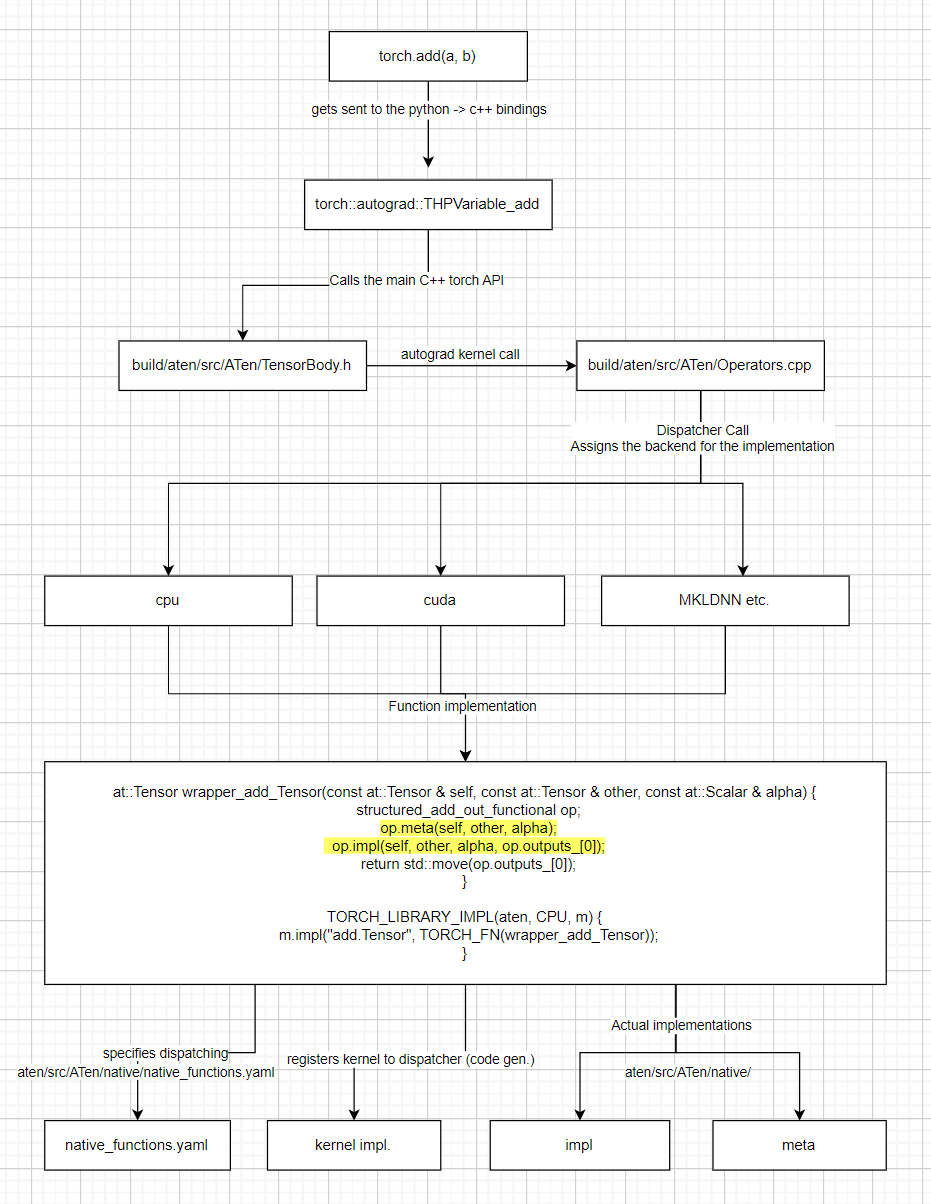


The image show the flow until the actual implementation. It works in 4 majors steps:

1. Python bindings
2. C++ API
3. Autograd Kernel (Dispatching)
4. CPU Kernel (Dispatching)

The first two steps are somewhat self-explanatory. Steps 3 and 4 get interesting, since they involve a dispatching mechanism (choosing what backend to send the input to). Unfortunately, there is no one-stop function that implements our desired functionality. Since torch is heavily optimized on the processor used by the calling function, there are different implementations for each backend, for each operation.

To prevent re-writing too much boilerplate code, Torch generates a lot of its code using .yaml files. So, writing code involves adding an entry to ```native_functions.yaml``` (and perhaps ```derivates.yaml```). And writing your c++ implementations in ```aten/src/Aten/native/```.

### 6.3.2 Implementing your own code -> Taken from pytorch docs

To create your own kernels involves writing a couple of different functions:

1. **YAML Metadata**

In native_functions.yaml. Specifies a function for each backend. Example add functions.

```yaml
- func: add.Tensor(Tensor self, Tensor other, *, Scalar alpha=1) -> Tensor
  device_check: NoCheck   # TensorIterator
  structured_delegate: add.out
  variants: function, method
  dispatch:
    SparseCPU, SparseCUDA, SparseMeta: add_sparse
    SparseCsrCPU, SparseCsrCUDA, SparseCsrMeta: add_sparse_csr
    MkldnnCPU: mkldnn_add
    ZeroTensor: add_zerotensor
    NestedTensorCPU, NestedTensorCUDA: NestedTensor_add_Tensor
```

**Explanation**:

- **func**: Defines the function name (`add.Tensor`) and its parameters (`Tensor self, Tensor other, Scalar alpha`).
- **device_check**: Specifies whether to check if all tensors are on the same device.
- **structured_delegate**: Points to `add.out`, indicating that the function will use the structured kernel defined for `add.out`.
- **variants**: Specifies that this function can be used as a method and as a function.
- **dispatch**: Maps various backends (e.g., SparseCPU, SparseCUDA) to their corresponding implementation functions (e.g., `add_sparse`).



The YAML file serves as a schema for your code and specifies the device implementations for the function. This metadata is essential for PyTorch's code generation system to create the necessary boilerplate and integration code.

> **Note:** You might also need to write your own derivative in `derivatives.yaml`.

For more information on YAML function definitions, visit the [PyTorch documentation on registering functions](https://github.com/pytorch/pytorch/blob/main/aten/src/ATen/native/README.md#registering-a-function-in-native_functionsyaml).

2. **Meta Function and Implementation Function**

   1. Meta function: "A "meta" function, which asserts that the inputs have the correct shape/dtype and figures out what size the output tensor should be. "[1]

      *Meta Function*

      ```c++
      	// expands to structured_add_Tensor::meta() { ... }
      TORCH_META_FUNC2(add, Tensor) (
        const Tensor& self, const Tensor& other, const Scalar& alpha
      ) {
        build_borrowing_binary_op(maybe_get_output(), self, other);
        native::alpha_check(dtype(), alpha);
      }```
      ```



2. "An “impl” function, which does the actual computation. *There will be a separate impl() function for every backend (cpu, cuda, xla, etc).*" [1]

   *Implementation function*

   ```c++
   // expands to structured_add_out::impl() { ... }
   TORCH_IMPL_FUNC(add_out) (
     const Tensor& self, const Tensor& other, const Scalar& alpha, const Tensor& result
   ) {
     add_stub(device_type(), *this, alpha);
     TORCH_INTERNAL_ASSERT(result.scalar_type() == output().dtype());
   }```
   ```

For more information on writing C++ implementations, visit the [PyTorch documentation on registering functions](https://github.com/pytorch/pytorch/blob/main/aten/src/ATen/native/README.md#registering-a-function-in-native_functionsyaml).

### 6.3.3 How these are all linked together

#### Linking the Names

1. **YAML Metadata to C++**:
   - The `func` entry `add.Tensor` and `structured_delegate: add.out` in the YAML file indicate that `add.Tensor` uses the structured kernel defined for `add.out`.
2. **Structured Kernel**:
   - The `add.out` kernel is implemented with the `TORCH_META_FUNC2(add, Tensor)` meta function and the `TORCH_IMPL_FUNC(add_out)` implementation function.

---

Once this is done, the rest of the code will be generated:

### 6.3.4 Code generation

Among other code, this will be generated: 

1. Function declarations

​	<u>NativeMetaFunctions.h</u>

```c++
// namespace at::meta
struct TORCH_API structured_add_Tensor : public TensorIteratorBase {
    void meta(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha);
};
```

​	<u>NativeFunctions.h</u>

```c++
// namespace at::native
struct TORCH_API structured_add_out : public at::meta::structured_add_Tensor {
    void impl(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha, const at::Tensor & out);
};
```
You can see that the codegen generated declarations for the two functions, and we hand-implemented them ourselves in BinaryOps.cpp. But how does the codegen use them?

The code-generated logic that stitches them together lives in the code-generated file RegisterCPU.cpp, and looks like this:
2. Integration Code

```cpp
// In RegisterCPU.cpp
at::Tensor wrapper_add_Tensor(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha) {
  structured_add_out_functional op;
  op.meta(self, other, alpha);
  op.impl(self, other, alpha, op.outputs_[0]);
  return std::move(op.outputs_[0]);
}

at::Tensor & wrapper_add__Tensor(at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha) {
  structured_add_out_inplace op(self);
  op.meta(self, other, alpha);
  op.impl(self, other, alpha, op.outputs_[0]);
  return self;
}

at::Tensor & wrapper_add_out_out(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha, at::Tensor & out) {
  structured_add_out_out op(out);
  op.meta(self, other, alpha);
  op.impl(self, other, alpha, op.outputs_[0]);
  return out;
}

TORCH_LIBRARY_IMPL(aten, CPU, m) {
  m.impl("add.Tensor", TORCH_FN(wrapper_add_Tensor));
  m.impl("add.out", TORCH_FN(wrapper_add_out_out));
  m.impl("add_.Tensor", TORCH_FN(wrapper_add__Tensor));
}

```
This is the "final" output - the 3 operators that we needed. The codegen created 3 new kernels, each of which call into our meta() and impl() functions. The only difference between the 3 is that they use different classes, each of which has a different implementation of set_output().
### 6.3.5 File Locations

- **YAML Metadata**: Located in `aten/src/ATen/native/native_functions.yaml`
- **Meta Function and Implementation Function**: Written in a relevant C++ file in `aten/src/ATen/native/`
- Generated Headers
  - `NativeMetaFunctions.h`: Found in the build directory, usually in `build/aten/src/ATen/`
  - `NativeFunctions.h`: Found in the build directory, usually in `build/aten/src/ATen/`
- **Integration Code**: Typically found in `aten/src/ATen/RegisterCPU.cpp` or equivalent files for other backends

## 6.4 Appendix

File Hierarchy word for word from [2]
1. First, torch/ contains what you are most familiar with: the actual Python modules that you import and use. This stuff is Python code and easy to hack on (just make a change and see what happens). However, lurking not too deep below the surface is...
2. torch/csrc/, the C++ code that implements what you might call the frontend of PyTorch. In more descriptive terms, it implements the binding code that translates between the Python and C++ universe, and also some pretty important pieces of PyTorch, like the autograd engine and the JIT compiler. It also contains the C++ frontend code.
3. aten/, short for "A Tensor Library" (coined by Zachary DeVito), is a C++ library that implements the operations of Tensors. If you're looking for where some kernel code lives, chances are it's in ATen. ATen itself bifurcates into two neighborhoods of operators: the "native" operators, which are modern, C++ implementations of operators, and the "legacy" operators (TH, THC, THNN, THCUNN), which are legacy, C implementations. The legacy operators are the bad part of town; try not to spend too much time there if you can.
4. c10/, which is a pun on Caffe2 and A"Ten" (get it? Caffe 10) contains the core abstractions of PyTorch, including the actual implementations of the Tensor and Storage data structures.

## Works Cited This section
[1] https://github.com/pytorch/pytorch/wiki/Codegen-and-Structured-Kernels

[2] http://blog.ezyang.com/2019/05/pytorch-internals/

[3] https://drive.google.com/file/d/16qPvpCF4Jbh7ss2lCQMk5hmcyzJvUyQj/view

# 7.0 Implementing the matrix squash in Torch's backend
## Background Problem
Previously, we tried a couple of different methods to improve convolutional layers computational speeds. Let's recap the main steps.
1. Re-implementating NaN Pooling logic as closely as possible in C++, using Torch Extensions.
   - Problem: Significantly slower, do not have the same level of optimizations
2. Install Torch source and modify the backend to accomodate the changes.
   - Problem: Cannot have access to the direct convolutional implementation. It is discovered that convolutions are re-written as matrix multiplications using Im2Col technique.
3. Current attempt, re-write the input in such a way to leverage the existing optimizations already in place.
  
**Pseudo-Code for matrix Squashing**

1. For all rows of the input matrix A:
    - Check if the number of NaNs > Threshold
        - If yes: remove row, and keep index where it was removed
        - Else: replace NaNs by 0, and continue with other rows
2. Perform convolution operation to obtain matrix C.
3. After receiving matrix C, re-insert NaNs in the indexes where the rows were deleted.

For a more in-depth exaplantion of all matrices (A, Band C) and how convolutions are implemented as matrix multiplications, see *Convolution as Matrix Multiplication*.

## Squashing/filtering the matrix (step 1)
To take full advantage of the matrix multiplication capabilities provided by the sgemm function in the BLAS library, it's crucial to ensure the input matrix, which contains the sliding windows, is compact. 
This is because these multiplication operations are optimized for dense matrices. 
Therefore, we cannot introduce gaps within the matrix, which would effectively make it sparse, as this would hinder performance. Hence, we re-create a matrix with the rows omitted.

### Using internal Torch C++ frontend.
The first technique to try was to use torch front end functions available. Our input was initialy given a contiguous memory location. So, from_blob was used to extract the given
matrice and load it into a tensor and filtered accordingly. 

```cpp
    auto A_tensor = from_blob((void*)a, {*k, *m}, at::kFloat);
    auto A_tensor_mask = (isnan(A_tensor).sum(0) < threshold);
    auto filtered_A_tensor = A_tensor.index({at::indexing::Slice(), A_tensor_mask});
```
While this could be written quickly enough, it did not allow for much customisation. Also, converting it to and from formats suitable for sgemm was not trivial, and would 
have involved playing with tensor memory, and torch internal tensor implementations. Hence this approach was discarded.

### Using vectors
A second approach was to use the vector data structure in C++ to handle going through. A vectors of vectors was created, which would point to the elements of the array. The outer vector
pointed to rows, and the innermost vector pointed to the indiviudal elements. While this made it easy to work with, it was eventually decided that it would involve too many copies of the
data (to the vector, and eventually re-written into contiguous memory). Also, vectors aren't the best in terms of speed.
```cpp
// We will use this to remove rows with NaNs
    std::vector<std::vector<const float*>> rows;

    // setting the elements of the array to point to the specific row
    for (int i = 0; i < *m; i++) { //m = num rows in A
        std::vector<const float*> row;
        for (int j = 0; j < *k; j++) { //k = common dimension
            int index = j * *lda + i;
            row.push_back(&a[index]); 
        }
        rows.push_back(row);
    }
    std::vector<int> removed_indexes = {}; 
    // counting the number of nans in each row and removes those that have nan above threshold
    int threshold = 2;
    int row_index = 0;
    // using the erase-remove idiom to remove rows with nans
    // marking the rows to remove
    rows.erase(
      std::remove_if(
        rows.begin(),
        rows.end(),
        [&removed_indexes, &threshold, &row_index] (const auto& row) {
            int nan_count = 0;
            for (const auto& element: row) {
                if (std::isnan(*element)) {
                    nan_count++;
                }
            }
            if (nan_count > threshold) {
                removed_indexes.push_back(row_index);
                row_index++;
                return true;
            }
            row_index++;
            return false;
          }
        ),
      rows.end()
    );
```
### Using dynamic memory and c-style arrays.
Finally it was settled that the most efficient way would be to work directly with the memory itself. This was tricky for two reasons (the memory was stored in column-major
organisation in memory (so that it could be sent and used efficiently by GEMM which runs on fortran). And the second, that both the input and the output needed to be contiguous memory locations.

A first tentative approach was built by converting everything to row major organisation, and having pointers pointing to these rows, but that involved too much overhead in copying and re-orgnaising.
So, the final approach was to work directly in matrix A. The input matrix A was looped through and re-written to a new contiguous memory location.
 > Bottleneck 1: This is the first major bottleneck in speed, we need to re-create a new memory location and copy the good rows over. No solution was found to implement in place yet. 

Here is the solution for step 1:
Some notation:  
**transa** and **transb**: Characters specifying whether matrices A and B are to be transposed.'N' for no transpose, 'T' for transpose, 'C' for conjugate transpose.  
 **m** and **n**: Dimensions of the matrices. m is the number of rows of A and C, n is the number of columns of B and C.  
 **k**: Common dimension for the multiplication. If A and B are the matrices being multiplied, A has dimensions m x k and B has dimensions k x n.  
 **alpha**: Scalar multiplier for the product of matrices A and B.  
 **a** and **b**: Pointers to the matrices being multiplied.  
 **lda** and **ldb**: Leading dimensions of matrices A and B. The leading dimension is the size of the memory storage of the matrix.  
 **beta**: Scalar multiplier for matrix C.  
 **c**: Pointer to the resultant matrix after multiplication.  
 **ldc**: Leading dimension of matrix C.  
```c++
 int nan_threshold = 2; // having more NaNs than this will delete the row
    bool* row_to_remove = new bool[*m];
    int rows_removed = 0;
    int new_m = *m;

    // Identify rows to remove
    for (int i = 0; i < *m; ++i) {
        int nan_count = 0;
        row_to_remove[i] = false;
        for (int j = 0; j < *k; ++j) {
            if (std::isnan(a[j * (*lda) + i])) {
                nan_count++;
                if (nan_count > nan_threshold) {
                    row_to_remove[i] = true;
                    new_m--;
                    rows_removed++;
                    break;
                }
            }
        }
    }

    // Allocate memory for the new matrix
    float* new_a = new float[new_m * (*k)];
    int new_row = 0;

    // Write the new matrix in column-major order
    for (int j = 0; j < *k; ++j) {
        new_row = 0;
        for (int i = 0; i < *m; ++i) {
            if (!row_to_remove[i]) {
                // if the value was supposed to be NaN, replace with 0
                if (std::isnan(a[j * (*lda) + i])) {
                    new_a[j * new_m + new_row] = 0;
                }
                else{
                    new_a[j * new_m + new_row] = a[j * (*lda) + i];
                }
                new_row++;
            }
        }
    }

    // Setting the pointer of a to this new memory location and updating sizes
    a = new_a;
    *m = new_m;
    *lda = new_m;
```
m, which stands for the number of rows in m and A and C, needs to be changed (in the subsequent code, m will refer to the rows of A).  
Likewise, lda is updated (which stands for leading dimension in matrix A). 
We need to update these so sgemm can work. However, we do not update the sizes of C, since we dont mind that the result of the multiplication
will be in a bigger memory location than it needs to since we will be re-inserting values in this.

When this is done, we call sgemm as follows:
```c++
  sgemm_(
        transa, transb,
        m, n, k,
        alpha,
        a, lda,
        b, ldb,
        beta,
        c, ldc);
```
This brings us to the final step.
## Re-inserting Nans
To do so, tried to methods the first was developped as follows: 
> Bottleneck 2: A second bottleneck is as follows: re-inserting into the matrix C wihtout shifting.
1. Using MEMCOPY

To do so, we will need to create a new matrix with the same dimensions as the original matrix C.
We will need to keep two pointers, one for the original matrix C and one in A, and iterate through the rows of C.
If a row was marked for removal, we will add NaNs to the row in C. Else, we will add the value that was
already in C.  
Best = Worst: O(n) time complexity and 2 copies.  
note: we are assuming that the matrix C is in column-major order, so no need calculate index
```c++
     float* new_c = new float[*ldc * *n];
     float* c_ptr = c;
     float* new_c_ptr = new_c;
     // Pointer to keep track of where we are in C, C is written back in column-major order
     for (int i = 0; i < *ldc; ++i) {
         if (row_to_remove[i]) {
             for (int j = 0; j < *n; ++j) {
                 *new_c_ptr = std::nanf("");
                 new_c_ptr++;
             }
         } else {
             for (int j = 0; j < *n; ++j) {
                 *new_c_ptr = *c_ptr;
                 new_c_ptr++;
                 c_ptr++;
             }
         }
     }
     // Copying over. Cant just change the pointer without changing a bunch of fct def
     memcpy(c, new_c, sizeof(float) * (*ldc) * (*n));
```
This wasnt the best, since the pointer for C was being passed in many different functions in Torch, one couldn't simply re-point the pointer C as this change wouldn't stay in the 
calling functions. Hence, the changes needed to be done in another memory location and copied back afterwards. This wasn't good. So another method was implemented.
2.  
  
Method 2: Right-to left in-place NaN insertions.  

To do so, we will keep two pointers in Matrix C and iterate from right to left. The first pointer will point to index *lda - 1. 
The second will point to C + *lda * *n - 1. If the value in the row is NaN, we will insert NaNs at the second pointer. Else, we will
insert at the second pointer, the value pointed by the first pointer.   
Best Case: 1 copy, O(n) time complexity  
Worst Case: 1 full copy, O(n) time complexity  
```c++
// Pointer 1: End of matrix C
float* c_ptr = c + *ldc * *n - 1;
// Pointer 2: At index *lda - 1
float* c_ptrLDA = c + *lda - 1;

// Algorithm
for (int i = *ldc - 1; i >= 0; --i){
  if (row_to_remove[i]){
      for (int j = 0; j < *n; ++j){
          *c_ptr = std::numeric_limits<float>::quiet_NaN();
          c_ptr--;
      }
  } else {
      for (int j = 0; j < *n; ++j){
          *c_ptr = *c_ptrLDA;
          c_ptr--;
          c_ptrLDA--;
      }
  }
}
```
Hence, looking at all intermediate steps, an example looks as follows (pay attention to the [17, NaN, NaN, NaN], in the 3rd quadrant. The intermediate has 15 rows since 1 window/row was removed.
But after insertion, everything is at its good place and all 16 rows are accounted for (the result of the removed one is -1).
Also, to make it easier to see the differences,
instead of inserting NaNs we inserted -1:  
Padding = 0, Stride = 1. 
```cpp
Input Tensor: 
tensor([[[[nan,  2., nan,  4.,  5.],
          [ 6., nan,  8.,  9., 10.],
          [11., 12., nan, 14., 15.],
          [16., 17., nan, 19., 20.],
          [nan, nan, nan, 24., 25.]]]])

Weight Tensor: 
tensor([[[[1., 1.],
          [1., 1.]]]])

Printing updated NaN removed matrix: 
Row 0: nan 2 6 nan 
Row 1: 2 nan nan 8 
Row 2: nan 4 8 9 
Row 3: 4 5 9 10 
Row 4: 6 nan 11 12 
Row 5: nan 8 12 nan 
Row 6: 8 9 nan 14 
Row 7: 9 10 14 15 
Row 8: 11 12 16 17 
Row 9: 12 nan 17 nan 
Row 10: nan 14 nan 19 
Row 11: 14 15 19 20 
Row 12: 16 17 nan nan 
Row 13: nan 19 nan 24 
Row 14: 19 20 24 25 

Printing after insertion 
Row 0: nan 
Row 1: nan 
Row 2: nan 
Row 3: 28 
Row 4: nan 
Row 5: nan 
Row 6: nan 
Row 7: 48 
Row 8: 56 
Row 9: nan 
Row 10: nan 
Row 11: 68 
Row 12: nan 
Row 13: -1 
Row 14: nan 
Row 15: 88 
Output after convolution: 
tensor([[[[nan, nan, nan, 28.],
          [nan, nan, nan, 48.],
          [56., nan, nan, 68.],
          [nan, -1., nan, 88.]]]])
torch.Size([1, 1, 4, 4])
```

The next steps are to parallelize the whole algorithm.


# Comments From Ines
TODO
Btw I looked over your midterm notebook, here are my comments, lmk if anything is unclear
1. Background
Clarify last sentence. The cause of the unstability is the fact that indices can change due to different implementations, etc. It is specifically the choice of index that causes the instability and we see it affect the model specifically with the max unpooling operation (a specific form of upsampling -- others do not have the same effect).
2. Introduction
For the project proposal I would drop/rephrase the last bit "and prevent uncertainty propagation...". The speed up is the primary goal analyzing the uncertainty of the custom function would be a stretch goal
3. Section 3
Rename to methodology and use subsections for Approach 1, etc
I like the example of the expected logic and expected results. It could be interesting adding a couple more examples to cover more cases of what we expect to happen
4. Section 4
Rename section to results and use subsections for different results for visualizing the difference between nanpool, CPP, etc results, maybe add a short sentence mentioning that we visualize the output as a rudimentary sanity check to make sure the results are comparable to one another + for difference we use torch pool as the reference (it's evident in the code but could be written up)
5. Overall I'd separate visualization from the runtime benchmark experiments, I'd structure it %%timeit experiments, box plot of execution times then visualization of results
Section 5 could be Approach 2 under section 4 results
6. Section 5.1 to ensure full reproducibility you should add the versions of packages you're installing (ex conda which versions of pytorch etc, same with git clone, which version of torch?)
7. Potential 5.2 section -- upcoming challenges for the rest of the COMP 490 project

## Works Cited:

[1] Alzubaidi, L., Zhang, J., Humaidi, A.J. et al. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. J Big Data 8, 53 (2021). https://doi.org/10.1186/s40537-021-00444-8

[2] Zhao, L., Zhang, Z. A improved pooling method for convolutional neural networks. Sci Rep 14, 1589 (2024). https://doi.org/10.1038/s41598-024-51258-6

[3] **TODO** https://scicomp.stackexchange.com/questions/10356/computational-complexity-of-2d-convolution